In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import pickle

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import xgboost as xgb
from sklearn.metrics import log_loss

# Goals of this notebook

The previous notebook covered a lot of information about building a machine learning model. We carefully analyzed and featurized our data, created train, validation and test datasets, introspected into our model to see what it was doing, learned about standard scaling, precision, recall, one-hot encoding and grid search.

Today, we'll see the power of tree-based techniques and how they remove the need for a lot of preprocessing we had to do yesterday.

Instead of reading in the files we created earlier this week, let's start from scratch.

### Read data - ignore cross-validation for now

In [4]:
DATA_PATH = "../data/walmart"
TRAIN_PATH = f"{DATA_PATH}/train.csv"
TEST_PATH = f"{DATA_PATH}/test.csv"

In [18]:
#create dataframes for each set
df = pd.read_csv(TRAIN_PATH) #read file again in case we did some operations that could cause leakage (fill nulls etc.)

#### Fill nulls

In [19]:
df.isnull().sum(axis=0)

TripType                    0
VisitNumber                 0
Weekday                     0
Upc                      4129
ScanCount                   0
DepartmentDescription    1361
FinelineNumber           4129
dtype: int64

In [20]:
df['Upc'].fillna(-1, inplace=True)
df['DepartmentDescription'].fillna("-1", inplace=True)
df['FinelineNumber'].fillna(-1, inplace=True)

**Note**: if we were filling nulls in a more complex way, for example by replacing nulls by median values or most frequent (mode) values, then we would have to ensure we only used the median/mode from the train set. But since we are just using a generic constant value, it doesn't matter.

### Simple model - predict trip type based on each ITEM!

#### Replace non-numerical values by integers

In [21]:
df.head() #make sure that you don't visit number as a feature

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


In [22]:
#convert certain cols to categories

df['Weekday'] = df['Weekday'].astype('category')
df['DepartmentDescription'] = df['DepartmentDescription'].astype('category')

In [23]:
df['Weekday'].cat.categories

Index(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'],
      dtype='object')

In [24]:
df['Weekday'].cat.codes.head()

0    0
1    0
2    0
3    0
4    0
dtype: int8

In [25]:
df_weekday_orig = df['Weekday'].copy()
df_department_orig = df['DepartmentDescription'].copy()

In [26]:
df['Weekday'] = df['Weekday'].cat.codes
df['DepartmentDescription'] = df['DepartmentDescription'].cat.codes

In [27]:
df.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,0,6.811315e+10,-1,21,1000.0
1,30,7,0,6.053882e+10,1,63,8931.0
2,30,7,0,7.410811e+09,1,51,4504.0
3,26,8,0,2.238404e+09,2,50,3565.0
4,26,8,0,2.006614e+09,2,50,1017.0


#### Alternate method:

Note we are being more careful with the code below to give a more realistic example of how code in Jupyter would be written to a library. We won't be using the function below further in this notebook.

In [100]:
def categorical_to_integer(df: pd.DataFrame, colname: str, cat_to_int:dict = {}, int_to_cat:dict = {}) -> (dict, dict):
    unique_values = df[colname].unique()
    N_unique_values = len(unique_values)

    
    if colname in cat_to_int: 
        raise ValueError("Already processed this column")
    cat_to_int[colname] = dict(zip(unique_values, np.arange(N_unique_values)))
    
    if colname in int_to_cat:
        raise ValueError("Already processed this column")
    int_to_cat[colname] = dict(zip(np.arange(N_unique_values), unique_values))
    
    return cat_to_int, int_to_cat

In [101]:
cat_to_int, int_to_cat = {}, {}
cat_to_int, int_to_cat = categorical_to_integer(df, "Weekday", cat_to_int, int_to_cat)

In [102]:
cat_to_int

{'Weekday': {'Friday': 0,
  'Saturday': 1,
  'Sunday': 2,
  'Monday': 3,
  'Tuesday': 4,
  'Wednesday': 5,
  'Thursday': 6}}

In [103]:
int_to_cat

{'Weekday': {0: 'Friday',
  1: 'Saturday',
  2: 'Sunday',
  3: 'Monday',
  4: 'Tuesday',
  5: 'Wednesday',
  6: 'Thursday'}}

Now we can use these dictionaries and pd.DataFrame.apply to map the names to integers.

#### End of alternate method

Our dataframe now has numeric values for Weekday and DepartmentDescription

In [28]:
df.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,0,6.811315e+10,-1,21,1000.0
1,30,7,0,6.053882e+10,1,63,8931.0
2,30,7,0,7.410811e+09,1,51,4504.0
3,26,8,0,2.238404e+09,2,50,3565.0
4,26,8,0,2.006614e+09,2,50,1017.0


In [30]:
df['DepartmentDescription'].head(10)

0    21
1    63
2    51
3    50
4    50
5    50
6    50
7    50
8    50
9    50
Name: DepartmentDescription, dtype: int8

In [31]:
print(df_department_orig.cat.categories[21])
print(df_department_orig.cat.categories[63])
print(df_department_orig.cat.categories[51])
print(df_department_orig.cat.categories[50])

FINANCIAL SERVICES
SHOES
PERSONAL CARE
PAINT AND ACCESSORIES


In [33]:
df_department_orig.head(10)

0       FINANCIAL SERVICES
1                    SHOES
2            PERSONAL CARE
3    PAINT AND ACCESSORIES
4    PAINT AND ACCESSORIES
5    PAINT AND ACCESSORIES
6    PAINT AND ACCESSORIES
7    PAINT AND ACCESSORIES
8    PAINT AND ACCESSORIES
9    PAINT AND ACCESSORIES
Name: DepartmentDescription, dtype: category
Categories (69, object): [-1, 1-HR PHOTO, ACCESSORIES, AUTOMOTIVE, ..., SPORTING GOODS, SWIMWEAR/OUTERWEAR, TOYS, WIRELESS]

### Ready for one first tree-based model?!

In [35]:
model = RandomForestClassifier(n_estimators=10, max_depth=None, n_jobs=-1)

In [36]:
model.fit(df.drop(['VisitNumber', 'TripType'], axis=1), df['TripType'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [37]:
pred = model.predict(df.drop(['VisitNumber', 'TripType'], axis=1))
pred_proba = model.predict_proba(df.drop(['VisitNumber', 'TripType'], axis=1))

In [38]:
print(pred[0:10])

[999  30  30  26  26  26   9  26  26  26]


In [40]:
print(pred_proba[0:5, :])
print(pred_proba.shape)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         1.        ]
 [0.         0.         0.         0.         0.         0.
  0.08666667 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.39       0.
  0.1        0.         0.         0.         0.         0.
  0.         0.         0.15333333 0.         0.         0.
  0.         0.27      ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.77

In [44]:
accuracy = (df['TripType']==pred).sum() / df.shape[0]
print(f'accuracy = {accuracy}')

accuracy = 0.5460780707638002


In [45]:
multi_log_loss = log_loss(df['TripType'].tolist(), pred_proba)
print(f'log loss = {multi_log_loss}')

log loss = 1.1927994979918544


**Notes**:

1. We are probably overfitting here given we didn't do cross-validation (and set max_depth to be arbitrary). We should extend this analysis to our train and val sets.

2. Even with the caveats in (1), this should shock you! We literally filled some null values, replaced some strings by integers and trained a model that predicts the trip type based on ONE product for each row and get reasonable performance. Let's explore the distribution of predictions for each visit number.

In [46]:
df['pred'] = pred

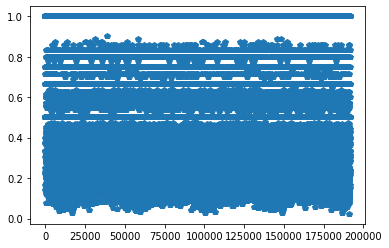

In [51]:
plt.plot(df.groupby('VisitNumber').agg({'pred': lambda x: len(np.unique(x)) / len(x)})['pred'].sort_values(), 'p')

The x-axis here is one value per visit number. The y-axis is the number of different predictions the random forest made for each trip (since we have one row per product not one row per visit). A value of 1 means each row in a particular visit was predicted to be a different trip type. A lower value means the model predicted almost the same trip type for every row.

Let's pick the most frequent value for each visit number and re-compute accuracy and log loss.

In [66]:
pred = df.groupby('VisitNumber').agg({'pred': lambda x: np.argmax(np.bincount(x))})

In [68]:
target = df[['VisitNumber', 'TripType']].set_index('VisitNumber')

In [70]:
comp = pd.concat([pred, target], axis=1)
print(comp.head())

             pred  TripType
VisitNumber                
5             999       999
7              30        30
7              30        30
8              26        26
8              26        26


In [72]:
accuracy = (comp['pred']==comp['TripType']).sum() / comp.shape[0]
print(accuracy)

0.7170375270070195


How should we deal with log loss? We need the probabilities. What we are going to do is the following:

* Pick the most frequent label (pred in comp above)

* Pick all the probability predictions for the rows where the most frequent label was predicted for a fixed visit number.

* Average these probabilities

This is a heuristic - there's no deep reason for it.

In [75]:
pred_proba.shape

(647054, 38)

# Questions to answer

exercise - change bootstrapping

why not 1-hot encoding

visualizing trees

treeinterpreter

extrapolation

hyperparameter tuning

bagging

boosting